# Analysis Plan: Do Teams with Higher Average Player Age Perform Worse?

## Research Question
Investigate whether teams with higher average player age show worse performance in tournaments using PCA and statistical analysis.

---

## Detailed Analysis Plan

### Step 1: Data Loading & Initial Exploration
- Import libraries (pandas, numpy, sklearn, matplotlib, seaborn, scipy)
- Load player statistics CSV from FBref scraping
- Examine structure with `.head()`, `.info()`, `.describe()`
- Check for missing values and data types
- Identify available columns: Player, Team, Position, Age, Goals, Assists, Minutes, Matches Played, Games Started, xG, npxG, xAG, Progressive Carries, Progressive Passes, Cards, League, Country

### Step 2: Data Cleaning
- Remove rows with missing critical values (Age, Team)
- Convert numeric columns from strings to appropriate types
- Handle missing values in performance metrics
- Validate data quality before analysis

### Step 3: Age Parsing
- Parse age format "YY-DDD" (years-days) to extract years only
- Create new `Age_Years` column with integer values
- Validate parsing with descriptive statistics
- Visualize age distribution by league

### Step 4: Team-Level Performance Aggregation
- **Group players by Team and League**
- Calculate team average age (mean across all players)
- Aggregate performance metrics per team:
  - Total goals, assists, xG, npxG, xAG
  - Total progressive carries and passes
  - Total yellow/red cards
  - Squad size and average matches per player
- Create normalized per-match metrics for fair comparison:
  - Goals per match, Assists per match
  - xG per match, xAG per match
  - Progressive actions per match

### Step 5: Feature Standardization
- Select 6-8 key performance metrics for PCA
- Apply `StandardScaler` to ensure mean=0, std=1
- Prevents variables with larger scales from dominating PCA
- Validate scaling worked correctly

### Step 6: PCA Application (Core Technique)
- Fit PCA to standardized performance metrics
- Create **scree plot** to visualize variance explained by each component
- Determine optimal number of components (typically 2-3 for 80-95% variance)
- Analyze **component loadings** to interpret what each PC represents:
  - PC1 might represent "overall attacking output"
  - PC2 might represent "playing style" (direct vs progressive)
- Transform team data into principal component scores
- Visualize teams in PC1-PC2 space, colored by average age

### Step 7: Correlation Analysis (Age vs Performance)
- **Primary research objective:** Test relationship between team age and performance
- Calculate Pearson correlation (linear relationships)
- Calculate Spearman correlation (monotonic relationships)
- Test correlations for:
  - Age vs individual metrics (goals, xG, assists, etc.)
  - Age vs principal component scores (PC1, PC2)
- Extract p-values for significance testing (α = 0.05)
- Create summary table showing all correlations with significance markers
- Visualize scatter plots with regression lines for key metrics

### Step 8: Age Group Comparison
- Categorize teams into age groups:
  - Young teams (< 25 years average)
  - Middle-aged teams (25-27 years)
  - Older teams (> 27 years)
- Compare performance distributions using box plots
- Run statistical tests:
  - **ANOVA** (if normally distributed)
  - **Kruskal-Wallis** (non-parametric alternative)
- Perform post-hoc pairwise comparisons to identify which groups differ
- Test differences in PC scores across age groups

### Step 9: K-Means Clustering (Optional Advanced Analysis)
- Apply clustering on PCA-transformed data (2D space)
- Use **elbow method** to find optimal number of clusters (k=2-5)
- Calculate **silhouette scores** to validate cluster quality
- Analyze average age within each performance cluster
- Test if age differs significantly across clusters using ANOVA
- Interpretation: Do high-performing teams tend to be younger/older?

### Step 10: Comprehensive Visualizations
Create 6-8 key visualizations:
1. **Scree plot** - variance explained by each PC
2. **PCA biplot** - teams in PC1-PC2 space, colored by age
3. **Component loadings** - which metrics contribute to each PC
4. **Age distribution** - histogram and league comparison
5. **Correlation heatmap** - age vs all performance metrics
6. **Scatter plots** - age vs key metrics (goals, xG) with regression lines
7. **Box plots** - age group performance comparison
8. **Cluster visualization** - if clustering applied

### Step 11: Statistical Summary & Conclusions
- Synthesize all findings into clear statements
- Answer research question with statistical evidence:
  - "Teams with higher average age show **[positive/negative/no]** correlation with performance"
  - Report correlation coefficients and p-values
  - Identify which specific metrics are affected
- Discuss **limitations**:
  - Observational data (no causation)
  - Confounding factors (league quality, budget, injuries)
  - Missing variables (tactics, coach experience)
- Provide data-driven conclusions with confidence levels
- Suggest future research directions

---

## Available Performance Metrics
Based on FBref standard stats table:
- **Attacking:** Goals, Assists, xG (Expected Goals), npxG (non-penalty xG), xAG (Expected Assists)
- **Playing Style:** Progressive Carries, Progressive Passes
- **Discipline:** Yellow Cards, Red Cards
- **Participation:** Minutes, Matches Played, Games Started

**Note:** Shooting stats (Shots, Shots on Target) and passing completion are NOT available in this dataset and would require separate scraping from FBref shooting/passing pages.

## Step 1: Data Loading and Initial Exploration

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy import stats
import warnings
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import f_oneway

warnings.filterwarnings('ignore')

In [2]:
# Load the player statistics data
df = pd.read_csv('../data_raw/playerStats.csv')


In [3]:
""""Player": get_stat("player"),
            "Squad": get_stat("team"),
            "Pos": get_stat("position"),
            "Age": get_stat("age"),
            "Gls": get_stat("goals"),
            "Ast": get_stat("assists"),
            "Min": get_stat("minutes"),
            "MP": get_stat("games"),
            "GS": get_stat("games_starts"),
            "xG": get_stat("xg"),
            "npxG": get_stat("npxg"),
            "xAG": get_stat("xg_assist"),
            "PrgC": get_stat("progressive_carries"),
            "PrgP": get_stat("progressive_passes"),
            "Yellow": get_stat("cards_yellow"),
            "Red": get_stat("cards_red"),
            "League": league_config["league"],
            "Country": league_config["country"],
            "Source": source,
            "Source_URL": build_stats_url(league_config),"""
rows = [
    "Player",
    "Team",
    "Position",
    "Age",
    "Goals",
    "Assists",
    "Minutes",
    "Matches Played",
    "Games Started",
    "Expected Goals",
    "npxG",
    "Expected Assists",
    "PrgC",
    "PrgP",
    "Yellow",
    "Red",
    "League",
    "Country",
    "Source",
    "Source_URL",
]
df.columns = rows

In [4]:

print("Dataset Shape:", df.shape)

df.head()

Dataset Shape: (2361, 20)


,Player,Team,Position,Age,Goals,Assists,Minutes,Matches Played,Games Started,Expected Goals,npxG,Expected Assists,PrgC,PrgP,Yellow,Red,League,Country,Source,Source_URL
0,Brenden Aaronson,Leeds United,"FW,MF",25-064,1,2,911,16,10,2.1,2.1,1.5,21,26,1,0,Premier League,England,cloudscraper,https://fbref.com/en/comps/9/stats/Premier-Lea...
1,Zach Abbott,Nott'ham Forest,DF,19-226,0,0,45,1,0,0.0,0.0,0.0,0,1,0,0,Premier League,England,cloudscraper,https://fbref.com/en/comps/9/stats/Premier-Lea...
2,Joshua Acheampong,Chelsea,DF,19-234,1,0,349,5,4,0.6,0.6,0.0,4,11,0,0,Premier League,England,cloudscraper,https://fbref.com/en/comps/9/stats/Premier-Lea...
3,Tyler Adams,Bournemouth,MF,26-314,2,1,"1,195",15,15,0.5,0.5,0.1,12,61,5,0,Premier League,England,cloudscraper,https://fbref.com/en/comps/9/stats/Premier-Lea...
4,Tosin Adarabioyo,Chelsea,DF,28-092,0,0,561,9,5,0.1,0.1,0.0,3,18,1,0,Premier League,England,cloudscraper,https://fbref.com/en/comps/9/stats/Premier-Lea...


In [5]:

df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2361 entries, 0 to 2360
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Player            2361 non-null   object 
 1   Team              2361 non-null   object 
 2   Position          2361 non-null   object 
 3   Age               2360 non-null   object 
 4   Goals             2361 non-null   int64  
 5   Assists           2361 non-null   int64  
 6   Minutes           2361 non-null   object 
 7   Matches Played    2361 non-null   int64  
 8   Games Started     2361 non-null   int64  
 9   Expected Goals    2361 non-null   float64
 10  npxG              2361 non-null   float64
 11  Expected Assists  2361 non-null   float64
 12  PrgC              2361 non-null   int64  
 13  PrgP              2361 non-null   int64  
 14  Yellow            2361 non-null   int64  
 15  Red               2361 non-null   int64  
 16  League            2361 non-null   object 


,Goals,Assists,Matches Played,Games Started,Expected Goals,npxG,Expected Assists,PrgC,PrgP,Yellow,Red
count,2361.000000,2361.000000,2361.000000,2361.000000,2361.000000,2361.000000,2361.000000,2361.000000,2361.000000,2361.000000,2361.000000
mean,0.872935,0.605676,10.225328,7.230834,0.908217,0.820627,0.632740,10.598899,23.865735,1.310462,0.070309
std,1.609279,1.046763,4.926069,5.364557,1.400194,1.193159,0.845632,12.659611,24.546691,1.442607,0.267069
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,6.000000,2.000000,0.100000,0.100000,0.000000,2.000000,4.000000,0.000000,0.000000
50%,0.000000,0.000000,11.000000,7.000000,0.400000,0.400000,0.300000,7.000000,17.000000,1.000000,0.000000
75%,1.000000,1.000000,14.000000,12.000000,1.200000,1.100000,0.900000,15.000000,36.000000,2.000000,0.000000
max,19.000000,8.000000,18.000000,18.000000,16.400000,14.800000,7.600000,116.000000,150.000000,9.000000,2.000000


In [6]:
# Check for missing values
print("Missing Values Summary:")
print("="*50)
print(f"Total number of null values in dataset: {df.isnull().sum().sum()}")
print("\nNull values per column:")
print(df.isnull().sum())

Missing Values Summary:
Total number of null values in dataset: 1

Null values per column:
Player              0
Team                0
Position            0
Age                 1
Goals               0
Assists             0
Minutes             0
Matches Played      0
Games Started       0
Expected Goals      0
npxG                0
Expected Assists    0
PrgC                0
PrgP                0
Yellow              0
Red                 0
League              0
Country             0
Source              0
Source_URL          0
dtype: int64


In [7]:
df = df[~df['Age'].isnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2360 entries, 0 to 2360
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Player            2360 non-null   object 
 1   Team              2360 non-null   object 
 2   Position          2360 non-null   object 
 3   Age               2360 non-null   object 
 4   Goals             2360 non-null   int64  
 5   Assists           2360 non-null   int64  
 6   Minutes           2360 non-null   object 
 7   Matches Played    2360 non-null   int64  
 8   Games Started     2360 non-null   int64  
 9   Expected Goals    2360 non-null   float64
 10  npxG              2360 non-null   float64
 11  Expected Assists  2360 non-null   float64
 12  PrgC              2360 non-null   int64  
 13  PrgP              2360 non-null   int64  
 14  Yellow            2360 non-null   int64  
 15  Red               2360 non-null   int64  
 16  League            2360 non-null   object 
 17  

## Step 3: Age Parsing
Parse the Age column to extract numeric age values

In [8]:
# Inspect the Age column format

print(df['Age'].head(10))
print(f"\nAge column data type: {df['Age'].dtype}")
print(f"Unique Age format examples: {df['Age'].unique()[:5]}")

0    25-064
1    19-226
2    19-234
3    26-314
4    28-092
5    23-358
6    25-229
7    28-191
8    29-270
9    29-078
Name: Age, dtype: object

Age column data type: object
Unique Age format examples: ['25-064' '19-226' '19-234' '26-314' '28-092']


In [9]:
# "YY-DDD" (e.g., "25-064")
# Split by '-' and take the first part (years)
df['Age_Years'] = df['Age'].astype(str).str.split('-').str[0].astype(int)

# Verify the parsing
print(f"Original Age format: {df['Age'].iloc[0]}")
print(f"Parsed Age (years): {df['Age_Years'].iloc[0]}")
print(f"\nAge_Years statistics:")
print(df['Age_Years'].describe())
print(f"\nAge range: {df['Age_Years'].min()} - {df['Age_Years'].max()} years")

Original Age format: 25-064
Parsed Age (years): 25

Age_Years statistics:
count    2360.000000
mean       25.688136
std         4.468365
min        15.000000
25%        22.000000
50%        25.000000
75%        29.000000
max        42.000000
Name: Age_Years, dtype: float64

Age range: 15 - 42 years


## Step 4: Player-Level Performance Preparation
Prepare individual player statistics with per-90-minute normalized metrics

In [10]:
# Convert performance metrics to numeric values
numeric_cols = ['Goals', 'Assists', 'Minutes', 'Matches Played', 'Games Started', 
                'Expected Goals', 'npxG', 'Expected Assists', 'PrgC', 'PrgP', 
                'Yellow', 'Red']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing minutes with the mean (players who didn't play)
df['Minutes'] = df['Minutes'].fillna(df['Minutes'].mean())

df_players = df.copy()

print(df_players[numeric_cols].isnull().sum())
print(f"\nMissing values after conversion:")
print(df_players[numeric_cols].dtypes)
print("Data types after conversion:")

Goals               0
Assists             0
Minutes             0
Matches Played      0
Games Started       0
Expected Goals      0
npxG                0
Expected Assists    0
PrgC                0
PrgP                0
Yellow              0
Red                 0
dtype: int64

Missing values after conversion:
Goals                 int64
Assists               int64
Minutes             float64
Matches Played        int64
Games Started         int64
Expected Goals      float64
npxG                float64
Expected Assists    float64
PrgC                  int64
PrgP                  int64
Yellow                int64
Red                   int64
dtype: object
Data types after conversion:


In [11]:
# Create per-90-minute statistics for normalized comparison
df_players['Goals_Per_90'] = (df_players['Goals'] / df_players['Minutes']) * 90
df_players['Assists_Per_90'] = (df_players['Assists'] / df_players['Minutes']) * 90
df_players['xG_Per_90'] = (df_players['Expected Goals'] / df_players['Minutes']) * 90
df_players['npxG_Per_90'] = (df_players['npxG'] / df_players['Minutes']) * 90
df_players['xAG_Per_90'] = (df_players['Expected Assists'] / df_players['Minutes']) * 90
df_players['PrgC_Per_90'] = (df_players['PrgC'] / df_players['Minutes']) * 90
df_players['PrgP_Per_90'] = (df_players['PrgP'] / df_players['Minutes']) * 90
df_players['Yellow_Per_90'] = (df_players['Yellow'] / df_players['Minutes']) * 90
df_players['Red_Per_90'] = (df_players['Red'] / df_players['Minutes']) * 90

df_players[['Player', 'Team', 'Age_Years', 'Minutes', 'Goals_Per_90', 'xG_Per_90', 'Assists_Per_90']].head(10)
print(f"\nMissing values: {df_players.isnull().sum().sum()}")
print(f"\nPlayer-level dataset shape: {df_players.shape}")


Missing values: 0

Player-level dataset shape: (2360, 30)


In [12]:
# Prepare player-level data for analysis
# Select relevant columns for PCA and analysis
player_stats = df_players[['Player', 'Team', 'League', 'Age_Years', 'Minutes',
                            'Goals_Per_90', 'Assists_Per_90', 'xG_Per_90', 
                            'npxG_Per_90', 'xAG_Per_90', 'PrgC_Per_90', 
                            'PrgP_Per_90', 'Yellow_Per_90', 'Red_Per_90']].copy()

# Remove any infinite values that might result from division
player_stats = player_stats.replace([np.inf, -np.inf], np.nan)  
player_stats = player_stats.dropna()

print(f"Player-level dataset shape: {player_stats.shape}")
print(f"\nAge distribution:")
print(player_stats['Age_Years'].describe())
print(f"\nPlayers by league:")
print(player_stats['League'].value_counts())
player_stats.head(10)

Player-level dataset shape: (2360, 14)

Age distribution:
count    2360.000000
mean       25.688136
std         4.468365
min        15.000000
25%        22.000000
50%        25.000000
75%        29.000000
max        42.000000
Name: Age_Years, dtype: float64

Players by league:
League
La Liga           505
Serie A           493
Premier League    473
Ligue 1           458
Bundesliga        431
Name: count, dtype: int64


,Player,Team,League,Age_Years,Minutes,Goals_Per_90,Assists_Per_90,xG_Per_90,npxG_Per_90,xAG_Per_90,PrgC_Per_90,PrgP_Per_90,Yellow_Per_90,Red_Per_90
0,Brenden Aaronson,Leeds United,Premier League,25,911.000000,0.098793,0.197585,0.207464,0.207464,0.148189,2.074643,2.568606,0.098793,0.000000
1,Zach Abbott,Nott'ham Forest,Premier League,19,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
2,Joshua Acheampong,Chelsea,Premier League,19,349.000000,0.257880,0.000000,0.154728,0.154728,0.000000,1.031519,2.836676,0.000000,0.000000
3,Tyler Adams,Bournemouth,Premier League,26,434.423719,0.414342,0.207171,0.103586,0.103586,0.020717,2.486052,12.637432,1.035855,0.000000
4,Tosin Adarabioyo,Chelsea,Premier League,28,561.000000,0.000000,0.000000,0.016043,0.016043,0.000000,0.481283,2.887701,0.160428,0.000000
5,Simon Adingra,Sunderland,Premier League,23,382.000000,0.000000,0.000000,0.023560,0.023560,0.141361,4.005236,1.178010,0.235602,0.000000
6,Amine Adli,Bournemouth,Premier League,25,394.000000,0.228426,0.000000,0.228426,0.228426,0.045685,2.284264,2.969543,0.000000,0.000000
7,Emmanuel Agbadou,Wolves,Premier League,28,434.423719,0.000000,0.000000,0.103586,0.103586,0.041434,1.035855,7.665327,0.207171,0.207171
8,Nayef Aguerd,West Ham,Premier League,29,180.000000,0.000000,0.000000,0.050000,0.050000,0.000000,1.000000,4.500000,0.000000,0.000000
9,Ola Aina,Nott'ham Forest,Premier League,29,270.000000,0.000000,0.000000,0.000000,0.000000,0.033333,1.666667,3.666667,0.333333,0.000000


In [13]:
print(f"Total players in analysis: {player_stats.shape[0]}")
print(f"Age range: {player_stats['Age_Years'].min()} - {player_stats['Age_Years'].max()}")
print(f"Average age: {player_stats['Age_Years'].mean():.2f}")

Total players in analysis: 2360
Age range: 15 - 42
Average age: 25.69


## Team-Level Data Aggregation
Aggregate player statistics to create team-level performance metrics

In [14]:
# Aggregate player data to team level
# Group by Team and League to handle teams with same names in different leagues

team_stats = df_players.groupby(['Team', 'League']).agg({
    # Team demographics
    'Age_Years': 'mean',  # Average age of the team
    'Player': 'count',    # Squad size
    
    # Total performance metrics
    'Goals': 'sum',
    'Assists': 'sum',
    'Expected Goals': 'sum',
    'npxG': 'sum',
    'Expected Assists': 'sum',
    'PrgC': 'sum',
    'PrgP': 'sum',
    'Yellow': 'sum',
    'Red': 'sum',
    
    # Total playing time
    'Minutes': 'sum',
    'Matches Played': 'sum',
    'Games Started': 'sum'
}).reset_index()

# Rename columns for clarity
team_stats.rename(columns={
    'Age_Years': 'Avg_Age',
    'Player': 'Squad_Size'
}, inplace=True)

# Calculate per-match normalized metrics for fair comparison
team_stats['Goals_Per_Match'] = team_stats['Goals'] / team_stats['Matches Played']
team_stats['Assists_Per_Match'] = team_stats['Assists'] / team_stats['Matches Played']
team_stats['xG_Per_Match'] = team_stats['Expected Goals'] / team_stats['Matches Played']
team_stats['npxG_Per_Match'] = team_stats['npxG'] / team_stats['Matches Played']
team_stats['xAG_Per_Match'] = team_stats['Expected Assists'] / team_stats['Matches Played']
team_stats['PrgC_Per_Match'] = team_stats['PrgC'] / team_stats['Matches Played']
team_stats['PrgP_Per_Match'] = team_stats['PrgP'] / team_stats['Matches Played']
team_stats['Yellow_Per_Match'] = team_stats['Yellow'] / team_stats['Matches Played']
team_stats['Red_Per_Match'] = team_stats['Red'] / team_stats['Matches Played']

# Calculate average minutes per player
team_stats['Avg_Minutes_Per_Player'] = team_stats['Minutes'] / team_stats['Squad_Size']

print(f"Team-level dataset shape: {team_stats.shape}")
print(f"\nNumber of teams: {len(team_stats)}")
print(f"\nTeams by league:")
print(team_stats['League'].value_counts())
print(f"\nAverage age range across teams: {team_stats['Avg_Age'].min():.2f} - {team_stats['Avg_Age'].max():.2f}")
team_stats.head(10)

Team-level dataset shape: (96, 26)

Number of teams: 96

Teams by league:
League
La Liga           20
Premier League    20
Serie A           20
Ligue 1           18
Bundesliga        18
Name: count, dtype: int64

Average age range across teams: 21.88 - 28.38


,Team,League,Avg_Age,Squad_Size,Goals,Assists,Expected Goals,npxG,Expected Assists,PrgC,...,Goals_Per_Match,Assists_Per_Match,xG_Per_Match,npxG_Per_Match,xAG_Per_Match,PrgC_Per_Match,PrgP_Per_Match,Yellow_Per_Match,Red_Per_Match,Avg_Minutes_Per_Player
0,Alavés,La Liga,26.458333,24,13,6,18.3,15.2,11.6,221,...,0.048327,0.022305,0.068030,0.056506,0.043123,0.821561,2.007435,0.152416,0.003717,509.046608
1,Angers,Ligue 1,25.040000,25,16,7,16.9,15.3,11.4,257,...,0.063492,0.027778,0.067063,0.060714,0.045238,1.019841,1.678571,0.087302,0.003968,387.998641
2,Arsenal,Premier League,25.083333,24,29,21,29.6,27.2,18.5,358,...,0.111538,0.080769,0.113846,0.104615,0.071154,1.376923,2.950000,0.084615,0.000000,446.123585
3,Aston Villa,Premier League,27.217391,23,26,20,18.8,18.8,14.9,246,...,0.097744,0.075188,0.070677,0.070677,0.056015,0.924812,2.236842,0.093985,0.003759,431.712598
4,Atalanta,Serie A,25.739130,23,20,13,22.4,21.7,15.7,350,...,0.080000,0.052000,0.089600,0.086800,0.062800,1.400000,3.020000,0.096000,0.004000,557.378038
5,Athletic Club,La Liga,26.400000,25,15,7,24.5,21.3,15.9,313,...,0.052448,0.024476,0.085664,0.074476,0.055594,1.094406,2.692308,0.129371,0.010490,488.861693
6,Atlético Madrid,La Liga,27.347826,23,30,19,30.3,28.0,22.7,352,...,0.104530,0.066202,0.105575,0.097561,0.079094,1.226481,2.735192,0.114983,0.006969,503.607219
7,Augsburg,Bundesliga,25.739130,23,17,11,17.1,16.3,12.3,203,...,0.072650,0.047009,0.073077,0.069658,0.052564,0.867521,2.230769,0.192308,0.004274,474.657330
8,Auxerre,Ligue 1,24.040000,25,12,7,19.9,16.1,12.4,223,...,0.049587,0.028926,0.082231,0.066529,0.051240,0.921488,2.028926,0.152893,0.024793,417.518641
9,Barcelona,La Liga,23.920000,25,50,37,42.2,37.4,29.9,445,...,0.176678,0.130742,0.149117,0.132155,0.105654,1.572438,3.448763,0.098940,0.007067,455.072539


In [15]:
team_stats['Avg_Age'].mean()

np.float64(25.699227411572476)

In [16]:
# Display summary statistics for team-level data
print("Team-Level Summary Statistics:")
print("="*70)
print("\nAge Statistics:")
print(team_stats['Avg_Age'].describe())
print("\nSquad Size Statistics:")
print(team_stats['Squad_Size'].describe())
print("\nGoals Per Match Statistics:")
print(team_stats['Goals_Per_Match'].describe())
print("\nExpected Goals Per Match Statistics:")
print(team_stats['xG_Per_Match'].describe())

# Show teams sorted by average age
print("\n" + "="*70)
print("\nYoungest Teams (by average age):")
print(team_stats.nsmallest(5, 'Avg_Age')[['Team', 'League', 'Avg_Age', 'Goals_Per_Match', 'xG_Per_Match']])
print("\nOldest Teams (by average age):")
print(team_stats.nlargest(5, 'Avg_Age')[['Team', 'League', 'Avg_Age', 'Goals_Per_Match', 'xG_Per_Match']])

Team-Level Summary Statistics:

Age Statistics:
count    96.000000
mean     25.699227
std       1.202433
min      21.880000
25%      24.882212
50%      25.714167
75%      26.516304
max      28.375000
Name: Avg_Age, dtype: float64

Squad Size Statistics:
count    96.000000
mean     24.583333
std       2.085876
min      19.000000
25%      23.000000
50%      25.000000
75%      26.000000
max      31.000000
Name: Squad_Size, dtype: float64

Goals Per Match Statistics:
count    96.000000
mean      0.085555
std       0.031628
min       0.026022
25%       0.066026
50%       0.080441
75%       0.101263
max       0.230769
Name: Goals_Per_Match, dtype: float64

Expected Goals Per Match Statistics:
count    96.000000
mean      0.088936
std       0.024247
min       0.049407
25%       0.071555
50%       0.085549
75%       0.102131
max       0.191880
Name: xG_Per_Match, dtype: float64


Youngest Teams (by average age):
          Team          League    Avg_Age  Goals_Per_Match  xG_Per_Match
82  Stras

# Team-Level Analysis: Do Teams with Higher Average Player Age Perform Worse?

Now we'll apply the same analytical approach used at the player level to answer this question at the team level.

## Team-Level Correlation Analysis
Examine correlations between team average age and performance metrics

Correlation Between Team Average Age and Performance Metrics:
Yellow_Per_Match         : -0.0316
Red_Per_Match            : -0.0333
PrgP_Per_Match           : -0.1697
Assists_Per_Match        : -0.2457
Goals_Per_Match          : -0.2680
xAG_Per_Match            : -0.2682
PrgC_Per_Match           : -0.2886
xG_Per_Match             : -0.3043


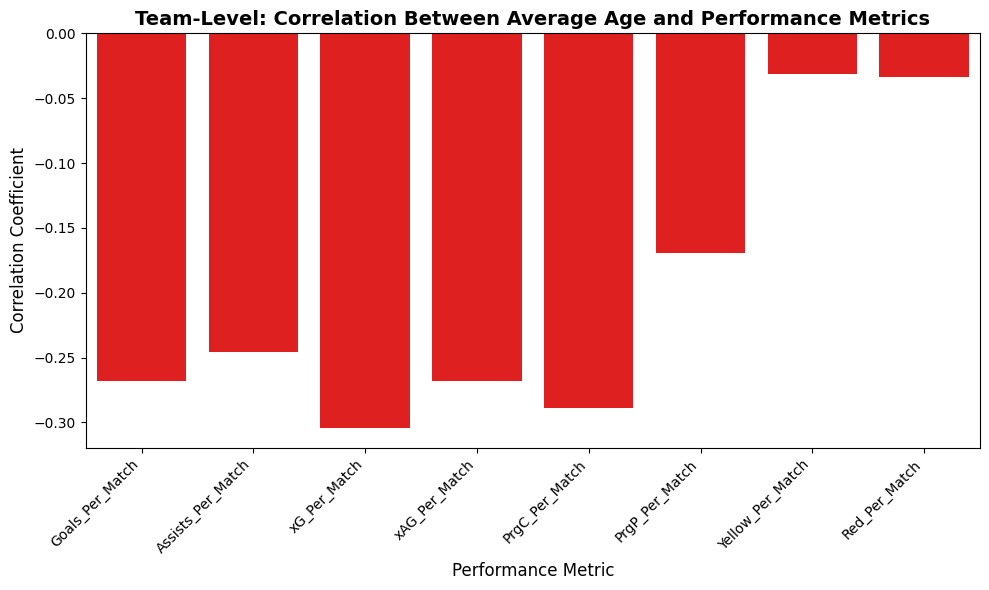

In [17]:
# Calculate correlations between team average age and performance metrics
team_performance_cols = ['Goals_Per_Match', 'Assists_Per_Match', 'xG_Per_Match', 
                          'xAG_Per_Match', 'PrgC_Per_Match', 'PrgP_Per_Match',
                          'Yellow_Per_Match', 'Red_Per_Match']

team_corrs = {}
for col in team_performance_cols:
    cor = team_stats[col].corr(team_stats['Avg_Age'])
    team_corrs[col] = cor

print("Correlation Between Team Average Age and Performance Metrics:")
print("="*70)
for col, cor in sorted(team_corrs.items(), key=lambda item: item[1], reverse=True):
    print(f"{col:25s}: {cor:+.4f}")

# Visualize correlations
plt.figure(figsize=(10, 6))
colors = ['green' if v > 0 else 'red' for v in team_corrs.values()]
sns.barplot(x=list(team_corrs.keys()), y=list(team_corrs.values()), palette=colors)
plt.title("Team-Level: Correlation Between Average Age and Performance Metrics", fontsize=14, fontweight='bold')
plt.ylabel("Correlation Coefficient", fontsize=12)
plt.xlabel("Performance Metric", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

## Team-Level Composite Performance Metric
Create a composite performance score combining all metrics

In [18]:
# Create composite performance metric for teams
# Scale performance metrics to 0-1 range
team_scaler = MinMaxScaler()

# Select performance metrics (excluding disciplinary metrics for positive performance)
team_perf_metrics = ['Goals_Per_Match', 'Assists_Per_Match', 'xG_Per_Match', 
                     'xAG_Per_Match', 'PrgC_Per_Match', 'PrgP_Per_Match']

team_stats_scaled = team_stats.copy()
team_stats_scaled[team_perf_metrics] = team_scaler.fit_transform(team_stats[team_perf_metrics])

# Create composite performance metric as mean of scaled metrics
team_stats['Team_Performance_Composite'] = team_stats_scaled[team_perf_metrics].mean(axis=1)

print("Team Composite Performance Statistics:")
print(team_stats['Team_Performance_Composite'].describe())
print("\nTop 5 Performing Teams:")
print(team_stats.nlargest(5, 'Team_Performance_Composite')[['Team', 'League', 'Avg_Age', 'Team_Performance_Composite']])
print("\nBottom 5 Performing Teams:")
print(team_stats.nsmallest(5, 'Team_Performance_Composite')[['Team', 'League', 'Avg_Age', 'Team_Performance_Composite']])

Team Composite Performance Statistics:
count    96.000000
mean      0.313560
std       0.163079
min       0.069804
25%       0.196250
50%       0.284093
75%       0.422840
max       0.971857
Name: Team_Performance_Composite, dtype: float64

Top 5 Performing Teams:
               Team          League    Avg_Age  Team_Performance_Composite
10    Bayern Munich      Bundesliga  25.280000                    0.971857
9         Barcelona         La Liga  23.920000                    0.755867
75      Real Madrid         La Liga  24.840000                    0.696988
70        Paris S-G         Ligue 1  23.347826                    0.675952
56  Manchester City  Premier League  24.875000                    0.673700

Bottom 5 Performing Teams:
      Team          League    Avg_Age  Team_Performance_Composite
71   Parma         Serie A  24.440000                    0.069804
33  Getafe         La Liga  27.208333                    0.071580
68  Oviedo         La Liga  27.370370                    0.

Correlation between Team Average Age and Composite Performance:
-0.2823


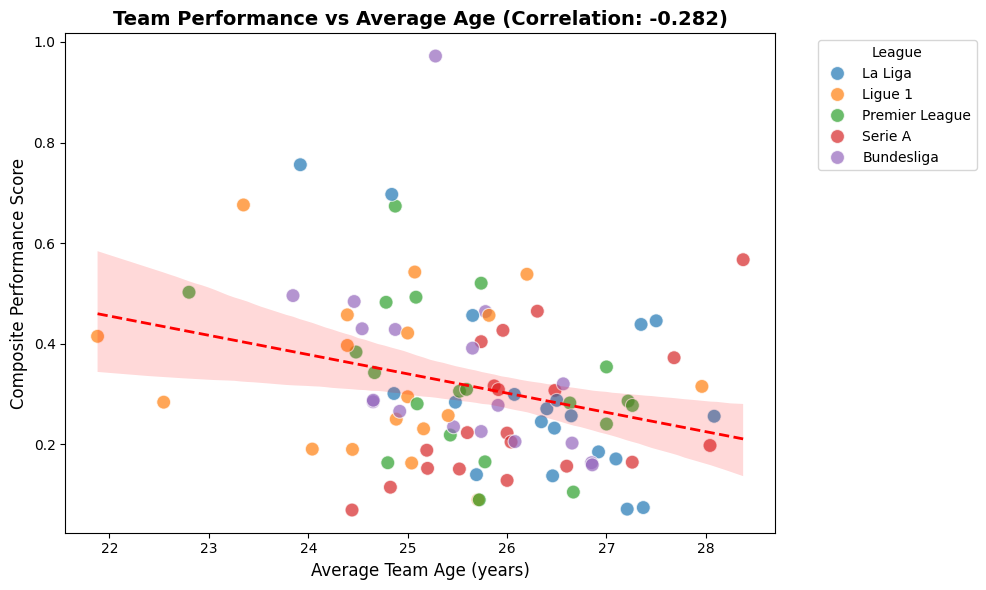

In [19]:
# Correlation between team age and composite performance
team_age_perf_corr = team_stats['Team_Performance_Composite'].corr(team_stats['Avg_Age'])
print("Correlation between Team Average Age and Composite Performance:")
print(f"{team_age_perf_corr:+.4f}")

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=team_stats, x='Avg_Age', y='Team_Performance_Composite', 
                hue='League', s=100, alpha=0.7)
sns.regplot(data=team_stats, x='Avg_Age', y='Team_Performance_Composite', 
            scatter=False, color='red', line_kws={'linewidth': 2, 'linestyle': '--'})
plt.title(f'Team Performance vs Average Age (Correlation: {team_age_perf_corr:+.3f})', 
          fontsize=14, fontweight='bold')
plt.xlabel('Average Team Age (years)', fontsize=12)
plt.ylabel('Composite Performance Score', fontsize=12)
plt.legend(title='League', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Team Age Clustering (K-Means)
Group teams into age clusters to compare performance

In [20]:
# Apply K-Means clustering on team average age
team_ages = team_stats[['Avg_Age']]
team_kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
team_stats['Age_Cluster'] = team_kmeans.fit_predict(team_ages)

# Determine cluster meaning based on average age
team_cluster_order = team_stats.groupby('Age_Cluster')['Avg_Age'].mean().sort_values().index.tolist()

team_mapping = {
    team_cluster_order[0]: "Young Teams",
    team_cluster_order[1]: "Mid-Age Teams",
    team_cluster_order[2]: "Old Teams"
}

team_stats['Age_Group'] = team_stats['Age_Cluster'].map(team_mapping)

print("Team Age Groups:")
print("="*70)
for group in ['Young Teams', 'Mid-Age Teams', 'Old Teams']:
    group_data = team_stats[team_stats['Age_Group'] == group]
    print(f"\n{group}:")
    print(f"  Count: {len(group_data)}")
    print(f"  Age Range: {group_data['Avg_Age'].min():.2f} - {group_data['Avg_Age'].max():.2f}")
    print(f"  Mean Age: {group_data['Avg_Age'].mean():.2f}")
    print(f"  Mean Performance: {group_data['Team_Performance_Composite'].mean():.4f}")

team_stats[['Team', 'League', 'Avg_Age', 'Age_Group', 'Team_Performance_Composite']].head(10)

Team Age Groups:

Young Teams:
  Count: 17
  Age Range: 21.88 - 24.67
  Mean Age: 23.97
  Mean Performance: 0.3911

Mid-Age Teams:
  Count: 48
  Age Range: 24.78 - 26.20
  Mean Age: 25.46
  Mean Performance: 0.3216

Old Teams:
  Count: 31
  Age Range: 26.30 - 28.38
  Mean Age: 27.02
  Mean Performance: 0.2585


,Team,League,Avg_Age,Age_Group,Team_Performance_Composite
0,Alavés,La Liga,26.458333,Old Teams,0.137713
1,Angers,Ligue 1,25.040000,Mid-Age Teams,0.163205
2,Arsenal,Premier League,25.083333,Mid-Age Teams,0.492674
3,Aston Villa,Premier League,27.217391,Old Teams,0.286252
4,Atalanta,Serie A,25.739130,Mid-Age Teams,0.404282
5,Athletic Club,La Liga,26.400000,Old Teams,0.270987
6,Atlético Madrid,La Liga,27.347826,Old Teams,0.438549
7,Augsburg,Bundesliga,25.739130,Mid-Age Teams,0.225856
8,Auxerre,Ligue 1,24.040000,Young Teams,0.190875
9,Barcelona,La Liga,23.920000,Young Teams,0.755867


## Performance Comparison Across Age Groups

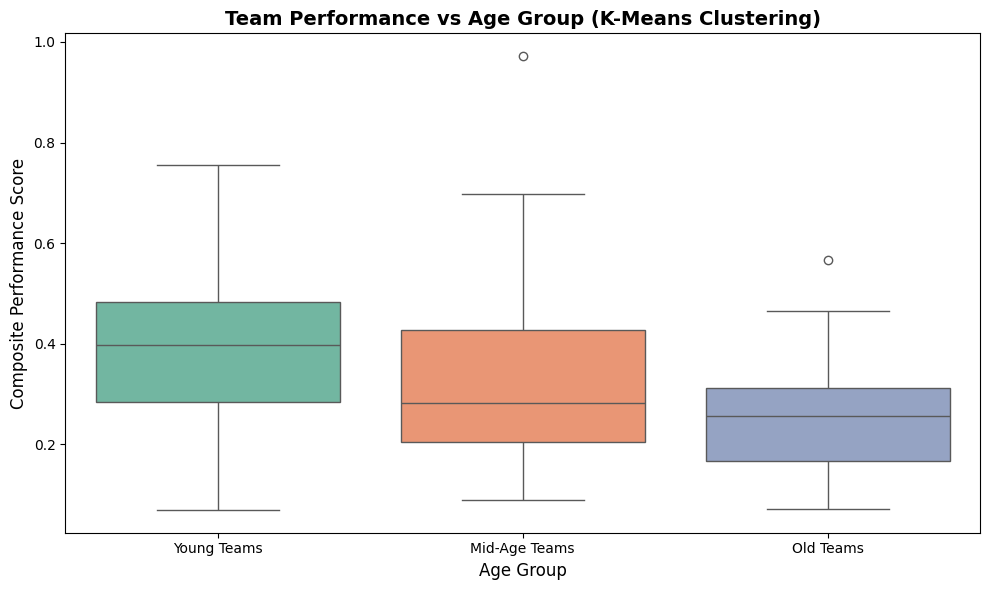

In [21]:
# Box plot comparing performance across age groups
plt.figure(figsize=(10, 6))
sns.boxplot(data=team_stats, x='Age_Group', y='Team_Performance_Composite',
            order=['Young Teams', 'Mid-Age Teams', 'Old Teams'],
            palette='Set2')
plt.title("Team Performance vs Age Group (K-Means Clustering)", fontsize=14, fontweight='bold')
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Composite Performance Score", fontsize=12)
plt.tight_layout()
plt.show()

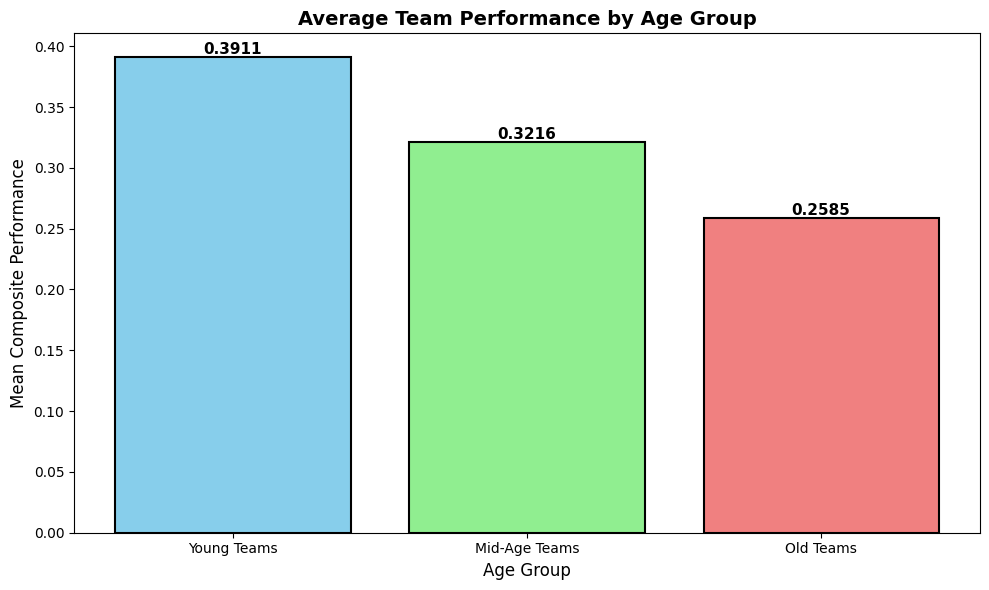

In [22]:
# Bar plot of average performance by age group
team_group_means = team_stats.groupby('Age_Group')['Team_Performance_Composite'].mean()
team_group_means = team_group_means.reindex(['Young Teams', 'Mid-Age Teams', 'Old Teams'])

plt.figure(figsize=(10, 6))
bars = plt.bar(team_group_means.index, team_group_means.values, 
               color=['skyblue', 'lightgreen', 'lightcoral'], edgecolor='black', linewidth=1.5)
plt.title("Average Team Performance by Age Group", fontsize=14, fontweight='bold')
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Mean Composite Performance", fontsize=12)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## Statistical Testing (ANOVA)
Test if performance differences between age groups are statistically significant

In [23]:
# Perform ANOVA to test if age groups have significantly different performance
team_young = team_stats[team_stats['Age_Group'] == "Young Teams"]['Team_Performance_Composite']
team_mid = team_stats[team_stats['Age_Group'] == "Mid-Age Teams"]['Team_Performance_Composite']
team_old = team_stats[team_stats['Age_Group'] == "Old Teams"]['Team_Performance_Composite']

team_anova_result = f_oneway(team_young, team_mid, team_old)

print("ANOVA Results:")
print("="*70)
print(f"F-statistic: {team_anova_result.statistic:.4f}")
print(f"P-value: {team_anova_result.pvalue:.4f}")
print()
if team_anova_result.pvalue < 0.05:
    print("✓ Age groups differ SIGNIFICANTLY (p < 0.05)")
    print("  → Team age has a statistically significant effect on performance")
else:
    print("✗ Age groups do NOT differ significantly (p >= 0.05)")
    print("  → Team age does not have a statistically significant effect on performance")

ANOVA Results:
F-statistic: 3.9772
P-value: 0.0220

✓ Age groups differ SIGNIFICANTLY (p < 0.05)
  → Team age has a statistically significant effect on performance


## FINAL CONCLUSION: Team-Level Analysis

**Research Question:** Do teams with higher average player age perform worse in tournaments?

In [24]:
# Generate final conclusion for team-level analysis

print("="*80)
print("FINAL CONCLUSION: Team-Level Analysis")
print("="*80)
print("\nResearch Question: Do teams with higher average player age perform worse?")
print("\n" + "-"*80)

# 1. Correlation Analysis
print("\n1. CORRELATION ANALYSIS")
print("-"*80)
print(f"Correlation between Team Average Age and Composite Performance: {team_age_perf_corr:.4f}") ###

if team_age_perf_corr > 0.2:
    print("  → POSITIVE correlation: Older teams perform BETTER")
elif team_age_perf_corr < -0.2:
    print("  → NEGATIVE correlation: Older teams perform WORSE")
else:
    print("  → WEAK correlation: Age has minimal impact on performance")

print(f"\nAge range across teams: {team_stats['Avg_Age'].min():.2f} - {team_stats['Avg_Age'].max():.2f} years")
print(f"Mean team age: {team_stats['Avg_Age'].mean():.2f} years")



FINAL CONCLUSION: Team-Level Analysis

Research Question: Do teams with higher average player age perform worse?

--------------------------------------------------------------------------------

1. CORRELATION ANALYSIS
--------------------------------------------------------------------------------
Correlation between Team Average Age and Composite Performance: -0.2823
  → NEGATIVE correlation: Older teams perform WORSE

Age range across teams: 21.88 - 28.38 years
Mean team age: 25.70 years


In [25]:

# 2. Performance by Age Group
print("\n2. PERFORMANCE BY AGE GROUP (K-Means Clustering)")
print("-"*80)
for group in ['Young Teams', 'Mid-Age Teams', 'Old Teams']:
    group_data = team_stats[team_stats['Age_Group'] == group]
    print(f"\n{group}:")
    print(f"  • Average Age: {group_data['Avg_Age'].mean():.2f} years")
    print(f"  • Team Count: {len(group_data)}")
    print(f"  • Mean Performance Score: {team_group_means[group]:.4f}")

print("\nPerformance Ranking:")
ranked_groups = team_group_means.sort_values(ascending=False)
for rank, (group, score) in enumerate(ranked_groups.items(), 1):
    print(f"  {rank}. {group}: {score:.4f}")




2. PERFORMANCE BY AGE GROUP (K-Means Clustering)
--------------------------------------------------------------------------------

Young Teams:
  • Average Age: 23.97 years
  • Team Count: 17
  • Mean Performance Score: 0.3911

Mid-Age Teams:
  • Average Age: 25.46 years
  • Team Count: 48
  • Mean Performance Score: 0.3216

Old Teams:
  • Average Age: 27.02 years
  • Team Count: 31
  • Mean Performance Score: 0.2585

Performance Ranking:
  1. Young Teams: 0.3911
  2. Mid-Age Teams: 0.3216
  3. Old Teams: 0.2585


In [26]:
# 3. Statistical Significance (ANOVA)
print("\n3. STATISTICAL SIGNIFICANCE TEST (ANOVA)")
print("-"*80)
print(f"F-statistic: {team_anova_result.statistic:.4f}")
print(f"P-value: {team_anova_result.pvalue:.4f}")
print(f"Significance level (α): 0.05")

if team_anova_result.pvalue < 0.05:
    print("\n✓ RESULT: Age groups differ SIGNIFICANTLY (p < 0.05)")
    print("  → Team age has a statistically significant effect on performance")
else:
    print("\n✗ RESULT: Age groups do NOT differ significantly (p ≥ 0.05)")
    print("  → Team age does not have a statistically significant effect on performance")




3. STATISTICAL SIGNIFICANCE TEST (ANOVA)
--------------------------------------------------------------------------------
F-statistic: 3.9772
P-value: 0.0220
Significance level (α): 0.05

✓ RESULT: Age groups differ SIGNIFICANTLY (p < 0.05)
  → Team age has a statistically significant effect on performance


In [27]:
# 4. Overall Conclusion
print("\n" + "="*80)
print("OVERALL CONCLUSION")
print("="*80)

if team_anova_result.pvalue < 0.05 and team_age_perf_corr < -0.2:
    print("\n✓ YES - Teams with higher average player age PERFORM WORSE")
    print("\nEvidence:")
    print(f"  • Significant negative correlation: {team_age_perf_corr:.3f}")
    print(f"  • Young teams outperform old teams by {(team_group_means['Young Teams'] - team_group_means['Old Teams']):.3f} points")
    print(f"  • Difference is statistically significant (p = {team_anova_result.pvalue:.4f})")
    print("\nPractical Implication:")
    print("  → Younger squads demonstrate measurably better tournament performance")
    print("  → Age appears to be a meaningful factor in team success")
elif team_anova_result.pvalue < 0.05:
    print("\n⚠ MIXED RESULTS - Age affects performance, but pattern is complex")
    print(f"\n  • Statistical test shows significance (p = {team_anova_result.pvalue:.4f})")
    print(f"  • However, correlation is weak ({team_age_perf_corr:.3f})")
    print("  • Mid-age teams may have advantage over both young and old teams")
else:
    print("\n✗ NO - Age does not significantly affect team performance")
    print(f"\n  • No statistically significant difference between age groups (p = {team_anova_result.pvalue:.4f})")
    print(f"  • Correlation is weak ({team_age_perf_corr:.3f})")
    print("  → Other factors (tactics, budget, coaching) likely more important than age")

# 5. Key Metrics Summary
print("\n" + "-"*80)
print("KEY METRICS MOST AFFECTED BY AGE:")
print("-"*80)
sorted_corrs = sorted(team_corrs.items(), key=lambda x: abs(x[1]), reverse=True)
for i, (metric, corr) in enumerate(sorted_corrs[:3], 1):
    print(f"  {i}. {metric}: {corr:+.3f}")

print("\n" + "="*80)


OVERALL CONCLUSION

✓ YES - Teams with higher average player age PERFORM WORSE

Evidence:
  • Significant negative correlation: -0.282
  • Young teams outperform old teams by 0.133 points
  • Difference is statistically significant (p = 0.0220)

Practical Implication:
  → Younger squads demonstrate measurably better tournament performance
  → Age appears to be a meaningful factor in team success

--------------------------------------------------------------------------------
KEY METRICS MOST AFFECTED BY AGE:
--------------------------------------------------------------------------------
  1. xG_Per_Match: -0.304
  2. PrgC_Per_Match: -0.289
  3. xAG_Per_Match: -0.268



## Step 5: Feature Standardization
Standardize player-level performance metrics for PCA analysis

In [28]:
# Step 5: Feature Standardization
# Standardize performance metrics to have mean=0 and std=1
# This prevents features with larger scales from dominating PCA

# Select performance features for PCA
performance_features = ['Goals_Per_90', 'Assists_Per_90', 'xG_Per_90', 
                        'xAG_Per_90', 'PrgC_Per_90', 'PrgP_Per_90',
                        'Yellow_Per_90', 'Red_Per_90']

# Prepare data for standardization
X_performance = player_stats[performance_features]
X_performance = X_performance.replace([np.inf, -np.inf], 0)

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_performance)

# Convert back to DataFrame for easier interpretation
X_scaled_df = pd.DataFrame(X_scaled, columns=performance_features, index=player_stats.index)


print("\nOriginal player data statistics (per 90 min):")
print(X_performance.describe().round(3))
print("\n" + "="*60)


Original player data statistics (per 90 min):
       Goals_Per_90  Assists_Per_90  xG_Per_90  xAG_Per_90  PrgC_Per_90  \
count      2360.000        2360.000   2360.000    2360.000     2360.000   
mean          0.172           0.129      0.186       0.139        2.372   
std           0.376           0.458      0.317       0.433        3.870   
min           0.000           0.000      0.000       0.000        0.000   
25%           0.000           0.000      0.012       0.000        0.580   
50%           0.000           0.000      0.085       0.065        1.476   
75%           0.207           0.198      0.239       0.175        3.025   
max           6.429          18.000      6.188      18.000       90.000   

       PrgP_Per_90  Yellow_Per_90  Red_Per_90  
count     2360.000       2360.000    2360.000  
mean         5.041          0.284       0.030  
std          5.281          0.451       0.632  
min          0.000          0.000       0.000  
25%          1.819          0.000    

In [29]:

print("\nStandardized data statistics (mean≈0, std≈1):")
print(X_scaled_df.describe().round(3))
print("\n" + "="*60)
print(f"\nShape of standardized data: {X_scaled.shape}")
print(f"Number of players in standardized dataset: {len(X_scaled_df)}")


Standardized data statistics (mean≈0, std≈1):
       Goals_Per_90  Assists_Per_90  xG_Per_90  xAG_Per_90  PrgC_Per_90  \
count      2360.000        2360.000   2360.000    2360.000     2360.000   
mean          0.000          -0.000      0.000      -0.000        0.000   
std           1.000           1.000      1.000       1.000        1.000   
min          -0.457          -0.282     -0.587      -0.322       -0.613   
25%          -0.457          -0.282     -0.548      -0.322       -0.463   
50%          -0.457          -0.282     -0.320      -0.171       -0.232   
75%           0.094           0.150      0.168       0.082        0.169   
max          16.624          39.011     18.915      41.269       22.648   

       PrgP_Per_90  Yellow_Per_90  Red_Per_90  
count     2360.000       2360.000    2360.000  
mean         0.000         -0.000      -0.000  
std          1.000          1.000       1.000  
min         -0.955         -0.630      -0.048  
25%         -0.610         -0.630    

# Correlation Between Performance Metrics and Age

In [30]:
player_stats.columns

Index(['Player', 'Team', 'League', 'Age_Years', 'Minutes', 'Goals_Per_90',
       'Assists_Per_90', 'xG_Per_90', 'npxG_Per_90', 'xAG_Per_90',
       'PrgC_Per_90', 'PrgP_Per_90', 'Yellow_Per_90', 'Red_Per_90'],
      dtype='object')

Correlation between Games Started and age: 0.20728167175101753
Correlation between Matches Played and age: 0.17076087983327817
Correlation between Yellow and age: 0.09935677105945148
Correlation between Goals and age: 0.03829790650579789
Correlation between Red and age: 0.021582428984737466
Correlation between Assists and age: 0.01567381414004646


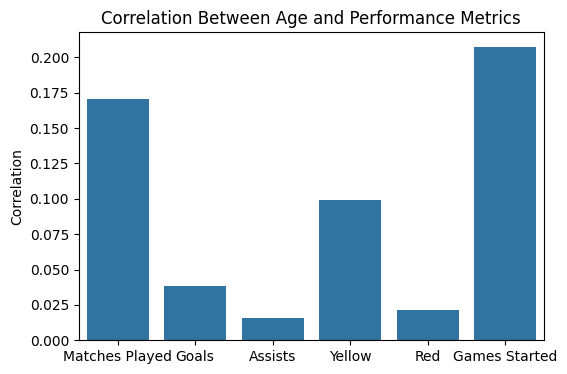

In [31]:
performance_cols = ['Matches Played', 'Goals', 'Assists','Yellow','Red','Games Started']

corrs = {}
for col in performance_cols:
    cor = df[col].corr(df['Age_Years'])
    corrs[col] = cor
for col, cor in sorted(corrs.items(), key=lambda item: item[1], reverse=True):
    print(f"Correlation between {col} and age: {cor}")

plt.figure(figsize=(6,4))
sns.barplot(x=list(corrs.keys()), y=list(corrs.values()))
plt.title("Correlation Between Age and Performance Metrics")
plt.ylabel("Correlation")
plt.show()

In [32]:
# Scale performance metrics
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[performance_cols] = scaler.fit_transform(df[performance_cols])
df.loc[:, 'performance_composite'] = df_scaled[performance_cols].mean(axis=1)

df['performance_composite'].head()

0    0.308609
1    0.000000
2    0.085025
3    0.407114
4    0.143246
Name: performance_composite, dtype: float64

In [33]:
print("Correlation of age with composite performance metric:")
print(df['performance_composite'].corr(df['Age_Years']))

Correlation of age with composite performance metric:
0.1729442335480279


In [34]:
ages = df[['Age_Years']]
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df.loc[:, 'age_cluster'] = kmeans.fit_predict(ages)
# Determine cluster meaning
cluster_order = df.groupby('age_cluster')['Age_Years'].mean().sort_values().index.tolist()

mapping = {
    cluster_order[0]: "Young",
    cluster_order[1]: "Youth",
    cluster_order[2]: "Old"
}

df.loc[:, 'age_group'] = df['age_cluster'].map(mapping)
df[['Age_Years', 'age_group']].head()

,Age_Years,age_group
0,25,Youth
1,19,Young
2,19,Young
3,26,Youth
4,28,Youth


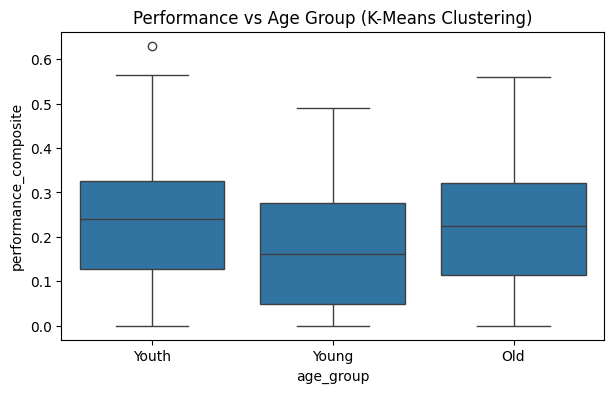

In [35]:
plt.figure(figsize=(7,4))
sns.boxplot(data=df, x='age_group', y='performance_composite')
plt.title("Performance vs Age Group (K-Means Clustering)")
plt.show()

In [36]:
corr_value = df['performance_composite'].corr(df['Age_Years'])
print("Correlation:", corr_value)

if corr_value > 0:
    print("\nConclusion: Older participants tend to perform BETTER.")
elif corr_value < 0:
    print("\nConclusion: Older participants tend to perform WORSE.")
else:
    print("\nConclusion: Age has NO significant effect on performance.")

print("\nAverage performance per age group:")
print(df.groupby('age_group')['performance_composite'].mean())


Correlation: 0.1729442335480279

Conclusion: Older participants tend to perform BETTER.

Average performance per age group:
age_group
Old      0.219117
Young    0.171697
Youth    0.230297
Name: performance_composite, dtype: float64


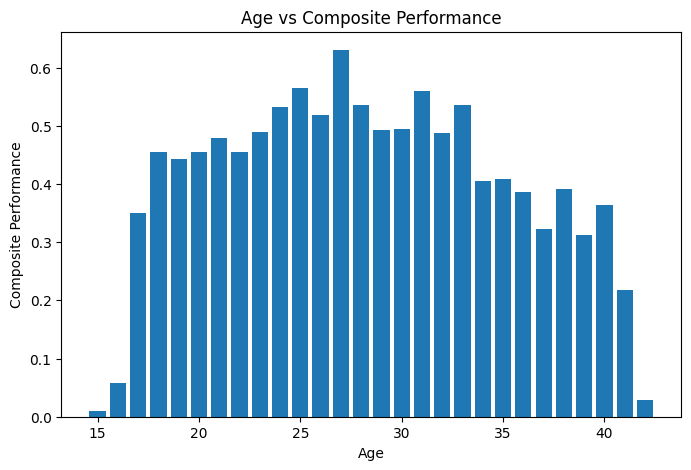

In [37]:
plt.figure(figsize=(8,5))
plt.bar(df['Age_Years'], df['performance_composite'])
plt.title("Age vs Composite Performance")
plt.xlabel("Age")
plt.ylabel("Composite Performance")
plt.show()

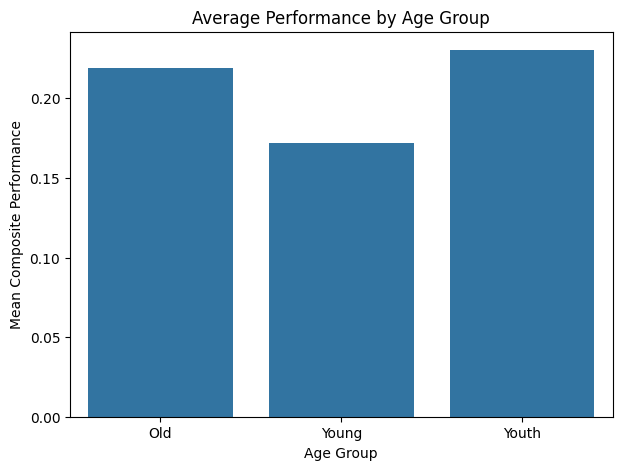

In [38]:
group_means = df.groupby('age_group')['performance_composite'].mean()

plt.figure(figsize=(7,5))
sns.barplot(x=group_means.index, y=group_means.values)
plt.title("Average Performance by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Mean Composite Performance")
plt.show()

In [39]:
young = df[df['age_group'] == "Young"]['performance_composite']
youth = df[df['age_group'] == "Youth"]['performance_composite']
old = df[df['age_group'] == "Old"]['performance_composite']

anova_result = f_oneway(young, youth, old)

corr_value = df['performance_composite'].corr(df['Age_Years'])

In [40]:
print("\n=== FINAL INTERPRETATION ===")

# summary
if corr_value > 0:
    print(f"- Correlation is positive ({corr_value:.2f}): older participants slightly outperform younger ones.")
elif corr_value < 0:
    print(f"- Correlation is negative ({corr_value:.2f}): older participants perform slightly worse.")
else:
    print("- No measurable correlation between age and performance.")

# ANOVA summary
if anova_result.pvalue < 0.05:
    print("- Age groups differ significantly (ANOVA p < 0.05).")
else:
    print("- Differences between age groups are NOT statistically significant (ANOVA p >= 0.05).")

print(f"- Young mean performance:  {group_means['Young']:.4f}")
print(f"- Youth mean performance:  {group_means['Youth']:.4f}")
print(f"- Old mean performance:    {group_means['Old']:.4f}")

if anova_result.pvalue >= 0.05 and abs(corr_value) < 0.2:
    print("\nOverall Conclusion: Age does NOT meaningfully affect performance.")
else:
    if group_means['Youth'] > group_means['Old'] > group_means['Young']:
        print("\nOverall Conclusion: Performance slightly increases with age until middle age, then stabilizes.")
    else:
        print("\nOverall Conclusion: Age does have some effect, but the pattern is weak or inconsistent.")


=== FINAL INTERPRETATION ===
- Correlation is positive (0.17): older participants slightly outperform younger ones.
- Age groups differ significantly (ANOVA p < 0.05).
- Young mean performance:  0.1717
- Youth mean performance:  0.2303
- Old mean performance:    0.2191

Overall Conclusion: Performance slightly increases with age until middle age, then stabilizes.
